# Convolutional Neural Networks (CNNs)

## MNIST handwritten digit recognition using Pytorch

In [432]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from torch import optim

In [433]:
transform=transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transform)
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [50000, 10000])

dataset_test = datasets.MNIST('./mnist', train=False, transform=transform)


In [434]:
print('Train Dataset Size:      ',len(dataset_train))
print('Validation Dataset Size: ',len(dataset_valid))
print('Test Dataset Size:       ',len(dataset_test))

Train Dataset Size:       50000
Validation Dataset Size:  10000
Test Dataset Size:        10000


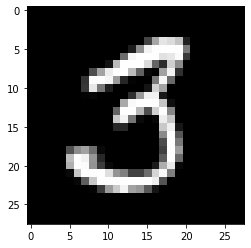

In [435]:
plt.imshow(dataset_train[1][0][0], cmap='gray')

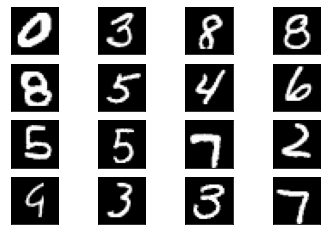

In [436]:
fig = plt.figure()
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(dataset_train[i][0].reshape(28, 28), cmap='Greys_r')

In [437]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [438]:
len(dataset_train)/64

781.25

In [439]:
print(len(train_loader))

782


In [440]:
#minibatch size = 64
batch_size = 64

In [441]:
#Data Loader of above tensor with minibatch size = 64 
train_loader = DataLoader(dataset_train, batch_size=batch_size)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size)
test_loader = DataLoader(dataset_test, batch_size=batch_size)

In [443]:
"""
Defining CNN model 
"""
class CNN(nn.Module):
    
    #Layer Architecture
    def __init__(self, input_shape=(1,28,28)):
        super(CNN, self).__init__()
        
        #layer 1; 25 filters of size 12*12*1, stride 2, no padding
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=25,
                               kernel_size=(12,12),
                               stride=(2,2),
                               padding=0,                  
            )
        
        #Layer 2; 64 filters of size 5*5*25, stride 1, padding = same
        self.conv2 = nn.Conv2d(in_channels = 25,
                               out_channels = 64,
                               kernel_size = (5,5),
                               stride = (1,1),
                               padding = 'same',
            )
        
        # Dropout rate 0.2
        self.dropout = nn.Dropout(p=0.2) 
        #fully connected layer 1 with 1024 units
        self.fc1 = nn.Linear (in_features = 4*4*64, out_features = 1024) #infeature??
        #fully connected layer 2 giving 10 outputs
        self.out = nn.Linear(in_features = 1024, out_features = 10)
        
    
    #Forward Pass
    def forward(self,x):
        
        x = F.relu(self.conv1(x)) #layer 1 followed by Relu
        x = F.relu(self.conv2(x)) #layer 2 followed by Relu 
        x = F.max_pool2d(x, 2, 2) #max-pool
        x = x.view(-1, 4*4*64)    #Flatten data for fully connected layer. 
                                  #Input size is 28*28, we have 2 convolutional and 1 pooling layer so spatial size is 9/2*9/2
                                  #With 64 filter as the output of the previous conv we have in total 4x4x64 features 
        x = F.relu(self.fc1(x))   #Relu following fully connected layer
        x = self.dropout(x)       #dropout layer to reduce overfitting
        x = self.out(x)           #output
        
        #PyTorch internally applies a log-softmax and negative-log-likelihood loss to compute the loss
        return x     

In [444]:
#class instance
model = CNN() 

In [445]:
num_epochs = 4
learning_rate = 1e-4 #Using Adam optimizer

In [446]:
#Define Loss Function 
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [447]:
#Using Adam optimizer for training 
optimizer = optim.Adam(model.parameters(), lr = learning_rate)  

In [461]:
#Error and accuracy list for every 100 iterations
train_error = []
test_error = []
valid_error = []
test_accuracy = []
valid_accuracy = []

In [449]:
#Train Model 

def train(num_epochs, total_itr):
    model.train()
    
    # loop over the data iterator, and feed the inputs to the network and adjust the weights.
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # Zero out gradients from previous step
        output = model(data) # Forward pass of the neural net
        loss = loss_func(output, target) #Loss function calculation
        loss.backward() #Backward pass (gradient computation)
        optimizer.step() #Updating weights
        
        if i%100 == 0:
            total_itr += 100
            print('Iterations: '+str(total_itr)+' Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.4f}'.format(num_epochs, i * len(data), len(train_loader.dataset),100.*i / len(train_loader), loss.item()))
            train_error.append(loss.item())
            
    return total_itr

In [450]:
def valid():
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)
            valid_loss += loss_func(output, target).item() #sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum()
            
    valid_loss /= len(valid_loader.dataset)    
    valid_error.append(valid_loss)
    valid_accuracy.append(100 * correct / len(valid_loader.dataset))
    print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(valid_loss, correct, len(valid_loader.dataset), 100. * correct / len(valid_loader.dataset)))
            

In [451]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # to avoid storing the computations performed for generating the output
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_func(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_error.append(test_loss)
    test_accuracy.append(100 * correct / len(test_loader.dataset))
    print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [452]:
total_iter = 0
valid()
test()
for epoch in range(1, num_epochs + 1):
    total_iter = train(epoch, total_iter)
    valid()
    test()


Validation set: Avg. loss: 0.0362, Accuracy: 1528/10000 (15.28%)
Test set: Avg. loss: 0.0362, Accuracy: 1523/10000 (15.23%)

Iterations: 100 Train Epoch: 1 [0/50000 (0.00%)]	Loss: 2.2933
Iterations: 200 Train Epoch: 1 [6400/50000 (12.79%)]	Loss: 0.3835
Iterations: 300 Train Epoch: 1 [12800/50000 (25.58%)]	Loss: 0.2234
Iterations: 400 Train Epoch: 1 [19200/50000 (38.36%)]	Loss: 0.2894
Iterations: 500 Train Epoch: 1 [25600/50000 (51.15%)]	Loss: 0.1262
Iterations: 600 Train Epoch: 1 [32000/50000 (63.94%)]	Loss: 0.3453
Iterations: 700 Train Epoch: 1 [38400/50000 (76.73%)]	Loss: 0.1508
Iterations: 800 Train Epoch: 1 [44800/50000 (89.51%)]	Loss: 0.1826

Validation set: Avg. loss: 0.0022, Accuracy: 9594/10000 (95.94%)
Test set: Avg. loss: 0.0019, Accuracy: 9611/10000 (96.11%)

Iterations: 900 Train Epoch: 2 [0/50000 (0.00%)]	Loss: 0.2134
Iterations: 1000 Train Epoch: 2 [6400/50000 (12.79%)]	Loss: 0.0501
Iterations: 1100 Train Epoch: 2 [12800/50000 (25.58%)]	Loss: 0.0620
Iterations: 1200 Trai

Text(0.5, 1.0, 'Traing Loss')

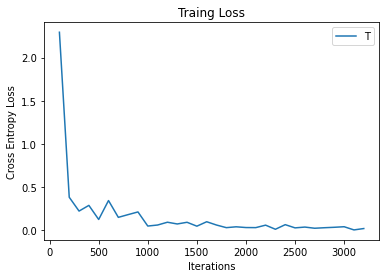

In [458]:
#Plotting Loss for training dataset
fig = plt.figure()
xaxis = np.arange(100,3300,100)
plt.plot(xaxis, train_error)
plt.legend('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('Traing Loss')

Text(0.5, 1.0, 'Validation vs Test Loss')

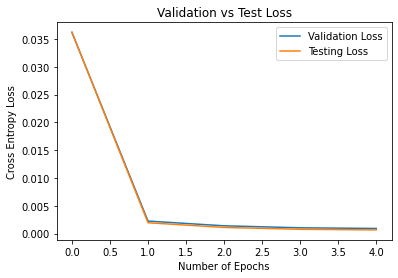

In [457]:
fig = plt.figure()
xaxis = np.arange(num_epochs+1)
plt.plot(xaxis,valid_error)
plt.plot(xaxis,test_error)
plt.legend(['Validation Loss', 'Testing Loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Validation vs Test Loss')

Text(0.5, 1.0, 'Validation and Test Accuracy')

<Figure size 432x288 with 0 Axes>

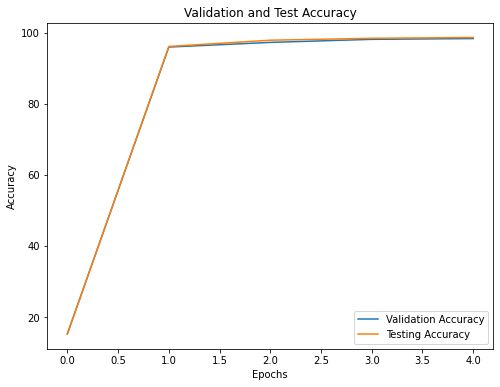

In [460]:
#Accuracy plot for valid and test data
from matplotlib.pyplot import figure

fig = plt.figure()
plt.figure(figsize=(8,6))
xaxis = np.arange(num_epochs+1)
plt.plot(valid_accuracy)
plt.plot(test_accuracy)
plt.legend(['Validation Accuracy', 'Testing Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy')



In [456]:
# model summary
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 25, 9, 9]            3,625
├─Conv2d: 1-2                            [-1, 64, 9, 9]            40,064
├─Linear: 1-3                            [-1, 1024]                1,049,600
├─Dropout: 1-4                           [-1, 1024]                --
├─Linear: 1-5                            [-1, 10]                  10,250
Total params: 1,103,539
Trainable params: 1,103,539
Non-trainable params: 0
Total mult-adds (M): 4.59
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 4.21
Estimated Total Size (MB): 4.28


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 25, 9, 9]            3,625
├─Conv2d: 1-2                            [-1, 64, 9, 9]            40,064
├─Linear: 1-3                            [-1, 1024]                1,049,600
├─Dropout: 1-4                           [-1, 1024]                --
├─Linear: 1-5                            [-1, 10]                  10,250
Total params: 1,103,539
Trainable params: 1,103,539
Non-trainable params: 0
Total mult-adds (M): 4.59
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 4.21
Estimated Total Size (MB): 4.28